In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric import nn as gnn

from graph_vae import GraphVAE
from train import train_loop2, loss_infer
from data_load import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

## Model Definition and training

In [3]:
net = GraphVAE()

In [4]:
train_loop2(net, 20, 64, 1e-3, device)

Epoch : 1 Loss: 6.10082 E mse: 3.67269 Hit mse: 310.73711
Epoch : 2 Loss: 2.87906 E mse: 1.57034 Hit mse: 128.68141
Epoch : 3 Loss: 2.45823 E mse: 1.56550 Hit mse: 105.71058
Epoch : 4 Loss: 2.31766 E mse: 1.56429 Hit mse: 98.13492
Epoch : 5 Loss: 2.23316 E mse: 1.56401 Hit mse: 93.42264
Epoch : 6 Loss: 2.17152 E mse: 1.56399 Hit mse: 89.88619
Epoch : 7 Loss: 2.12476 E mse: 1.56399 Hit mse: 87.15392
Epoch : 8 Loss: 2.08657 E mse: 1.56396 Hit mse: 84.86333
Epoch : 9 Loss: 2.05021 E mse: 1.56398 Hit mse: 82.62664
Epoch : 10 Loss: 2.00816 E mse: 1.56398 Hit mse: 79.98664
Epoch : 11 Loss: 1.96911 E mse: 1.56397 Hit mse: 77.52564
Epoch : 12 Loss: 1.93356 E mse: 1.56396 Hit mse: 75.28540
Epoch : 13 Loss: 1.89525 E mse: 1.56396 Hit mse: 72.86949
Epoch : 14 Loss: 1.86149 E mse: 1.56397 Hit mse: 70.73759
Epoch : 15 Loss: 1.83606 E mse: 1.56396 Hit mse: 69.12179
Epoch : 16 Loss: 1.81277 E mse: 1.56396 Hit mse: 67.65224
Epoch : 17 Loss: 1.79262 E mse: 1.56396 Hit mse: 66.37739
Epoch : 18 Loss: 1.7

In [4]:
torch.save(net.state_dict(), "Saves/L_50k_norand.pth")

tensor(0.0100)

## Inference and tests

In [2]:
from data_load import get_train_dataset

In [6]:
# def reconstruct_img(Y, counts):
#     xhit, yhit = Y[:, :, 0], Y[:, :, 1]
#     val = Y[:, :, 2]/50.
    
#     xhit = (xhit % 125).int()
#     yhit = (yhit % 125).int()
    
#     ecal = torch.zeros((Y.shape[0], 125, 125))
#     for j in range(Y.shape[0]):
#         # Add fancy/optimized indexing later
#         for i in range(counts[j]):
#             ecal[j, xhit[j, i], yhit[j, i]] += 0.1*(i/counts[j])# val[j, i]
    
#     return ecal

# def loss_infer2(net, x):
#     """
#     Inference loss function
#     """
#     # Graph nodes and edges
#     X, A, mask, counts = preprocess(x)
#     # Reconstructed nodes and edges
#     Y, A2, mu, logvar, L1, L2 = net(X, A, mask)
    
#     # Convert back to image
#     ecal = reconstruct_img(Y, counts)
    
#     mse = torch.nn.MSELoss()
    
#     return mse(X, Y), ecal, counts
    

In [3]:
def reconstruct_img2(Y, counts):
    xhit, yhit = Y[:, :, 0], Y[:, :, 1]
    val = Y[:, :, 2]/50.
    
    xhit = (xhit % 125).int()
    yhit = (yhit % 125).int()
    
    ecal = torch.zeros((Y.shape[0], 125, 125))
    for j in range(Y.shape[0]):
        # Add fancy/optimized indexing later
        for i in range(counts[j]):
            ecal[j, xhit[j, i], yhit[j, i]] += val[j, i]
    
    return ecal

def loss_infer2(net, X, A, mask):
    """
    Inference loss function
    """
    # Reconstructed nodes and edges
    Y, A2, mu, logvar, L1, L2 = net(X, A, mask)
    counts = torch.sum(mask, 1).int()
    # Convert back to image
    ecal = reconstruct_img2(Y, counts)
    
    mse = torch.nn.MSELoss()
    
    return mse(X, Y), ecal, A2

In [4]:
net = GraphVAE()
net.load_state_dict(torch.load("Saves/Checkpoints/ep_20.pth"))

<All keys matched successfully>

In [5]:
dataset = Train_Dataset(64)
data_loader = torch.utils.data.DataLoader(dataset)

In [6]:
for (X, A, mask) in data_loader:
    X = X[0]
    A = A[0]
    mask = mask[0]
    counts = torch.sum(mask, 1).int()
    with torch.no_grad():
        img1 = reconstruct_img2(X, counts)
        L, img2, A2 = loss_infer2(net, X, A, mask)
    break

tensor(-11.7747)
tensor(-2.3988)
tensor(-2.3988)
tensor(-11.7747)


In [8]:
A.sum(1), A2.sum(1)

(tensor([[6., 6., 6.,  ..., 0., 0., 0.],
         [6., 6., 6.,  ..., 0., 0., 0.],
         [6., 6., 6.,  ..., 0., 0., 0.],
         ...,
         [6., 6., 6.,  ..., 0., 0., 0.],
         [6., 6., 6.,  ..., 0., 0., 0.],
         [6., 6., 6.,  ..., 0., 0., 0.]]),
 tensor([[927.2907, 934.0000, 901.3362,  ...,  32.0000,  37.0000,  55.0000],
         [549.0000, 546.0000, 550.0135,  ..., 107.0000, 453.0000,  72.0000],
         [757.0000, 756.0000, 751.0000,  ...,  98.0000, 161.0000, 109.0000],
         ...,
         [703.0000, 705.0000, 705.0000,  ...,  57.0000, 230.0000, 136.0000],
         [847.0627, 879.0000, 562.1369,  ..., 106.0000, 114.0000, 114.0000],
         [713.0000, 711.0000, 704.0000,  ...,  82.0000,  89.0000, 181.0000]]))

In [22]:
img2.max()

tensor(0.)

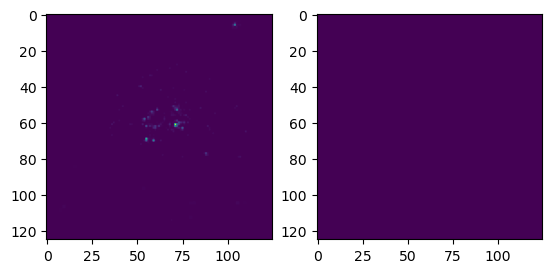

In [21]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[3]*(256))
ax[1].imshow(img2[3]*(256))
plt.show()

## Graph dataset

In [25]:
f = h5.File("quark-gluon_data-set_n139306.hdf5")
print(f['X_jets'].shape)
f.close()

(139306, 125, 125, 3)


In [3]:
from data_load import preprocess

In [4]:
with h5.File('quark_jets_ecal.h5', 'w') as g:
    f = h5.File('quark-gluon_data-set_n139306.hdf5', 'r')
    
    dset = g.create_dataset('x', shape=(0, 125, 125, 3), dtype=np.float32,
                            maxshape=(None, 125, 125, 3))
    L = 100_000
    w = 10_000

    for i in range(10):
        x, y = f['X_jets'][i*w: (i+1)*w], f['y'][i*w: (i+1)*w]
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        (ind_0,) = torch.nonzero(y==0, as_tuple=True)
        x = x[ind_0]
        curr_shape = dset.shape[0]
        dset.resize((curr_shape+x.shape[0], 125, 125, 3))
        dset[curr_shape:, :, :] = x
    print(dset.shape[0])
    f.close()

50000


In [2]:
with h5.File('quark_jets_ecal.h5') as g:
    with h5.File('quark_3chan_graph.h5', 'w') as h:
        X_dset = h.create_dataset('X', shape=(0, 1000, 4), dtype=np.float32,
                            maxshape=(None, 1000, 4))
        A_dset = h.create_dataset('A', shape=(0, 1000, 1000), dtype=np.float32,
                            maxshape=(None, 1000, 1000))
        mask_dset = h.create_dataset('mask', shape=(0, 1000), dtype=np.float32,
                            maxshape=(None, 1000))
        
        device = torch.device("cpu")
        w = 2000
        for i in range(25):
            x = g['x'][i*w: (i+1)*w]
            x = torch.from_numpy(x).to(device)
            X, A, mask, _ = preprocess(x, device)
            
            curr_shape = X_dset.shape[0]
                
            X_dset.resize((curr_shape+w, 1000, 4))
            A_dset.resize((curr_shape+w, 1000, 1000))
            mask_dset.resize((curr_shape+w, 1000))
            
            X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
            A_dset[curr_shape:, :, :] = A.to("cpu").numpy()
            mask_dset[curr_shape:, :] = mask.to("cpu").numpy()

In [3]:
with h5.File('quark_ecal_graph.h5') as h:
    print(h['X'].shape)
    print(h['A'].shape)
    print(h['mask'].shape)

(50000, 300, 3)
(50000, 300, 300)
(50000, 300)
